# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

## Generating the Data

In [2]:
# Measurement

u_obs = np.array([1.1,1.0,1.1,-2.7,0.0])
u_gt = np.array([1.0,1.0,1.0,-3.0,0.0])

# Pose
x_i = np.array([0.0,1.1,2.1,3.2,0.5])
x_gt = np.array([0.0,1.0,2.0,3.0,0.0])

## Function and Derivatives

In [3]:
def constraint_fn(x,u):
    # Odometry Constraint
    f = np.array([[x[0] + u[0] - x[1]],[x[1] + u[1] - x[2]],[x[2] + u[2] - x[3]],[x[3] + u[3] - x[4]]])

    # Loop Closure Constraint
    f = np.append(f,[x[0] + u[4] - x[4]])

    # Prior Contraint
    f = np.append(f,[x[0] - 0])

    # f is a column vector
    return f.reshape((-1,1))

def get_jacobian():
    dx0 = np.array([1,0,0,0,1,1])
    dx1 = np.array([-1,1,0,0,0,0])
    dx2 = np.array([0,-1,1,0,0,0])
    dx3 = np.array([0,0,-1,1,0,0])
    dx4 = np.array([0,0,0,-1,-1,0])

    return np.vstack([dx0,dx1,dx2,dx3,dx4]).T

# The Information Matrix
inf_mat = np.array([[100,0,0,0,0,0],
                    [0,100,0,0,0,0],
                    [0,0,100,0,0,0],
                    [0,0,0,100,0,0],
                    [0,0,0,0,100,0],
                    [0,0,0,0,0,1000]])

In [4]:
def error_fn(x,u,inf_mat):
    r = constraint_fn(x,u).reshape((-1,1))

    return np.squeeze(1/2 * r.T@inf_mat@r)

## Gauss-Newton

In [5]:
def optimize(x_i,u_obs,inf_mat,jacobian,num_iters=1000):
    error = [error_fn(x_i,u_gt,inf_mat)]
    x = x_i
    H = jacobian.T@inf_mat@jacobian

    print("Initial")
    print("Error : ",error_fn(x_i,u_gt,inf_mat))
    for i in range(num_iters):
        b = jacobian.T@inf_mat.T@constraint_fn(x,u_obs)
        del_x = -np.linalg.inv(H)@b.flatten()
        x += del_x
        error.append(error_fn(x,u_gt,inf_mat))
        print("Iteration : ",i)
        print("Error : ",error[-1])

    return error

In [6]:
sol = optimize(x_i,u_obs,inf_mat,get_jacobian(),num_iters=10)

Initial
Error :  17.999999999999996
Iteration :  0
Error :  2.9999999999999925
Iteration :  1
Error :  2.999999999999999
Iteration :  2
Error :  2.999999999999998
Iteration :  3
Error :  2.999999999999998
Iteration :  4
Error :  2.999999999999998
Iteration :  5
Error :  2.999999999999998
Iteration :  6
Error :  2.999999999999998
Iteration :  7
Error :  2.999999999999998
Iteration :  8
Error :  2.999999999999998
Iteration :  9
Error :  2.999999999999998


## Plots

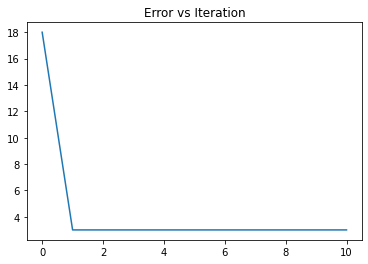

In [8]:
plt.title('Error vs Iteration')
plt.plot(sol)

It can be seen that the function converged to the optima in a single step. This is due to the fact that this is a linear least square problem with a closed form solution and thus optimizes in a single step